# Intro
**Goal**: To detect metestatic patches in small images taken from large pathology scans. 

**How:** Creating a basic CNN and then a modified efficientnet CNN utlizing transfer learning

**Data:** 

Train Folder: 220k .tif files

Test Folder: 57.5k .tif files

Train_Labels.csv: 220025 rows with id and target label (1 or 0)

Submission.CSV: 57458 rows with id and target lavel (1 or 0)

# Data Preprocessing/EDA

In [2]:
from google.colab import files
files.upload() #upload kaggle.json

#linux commands to create.kaggle folder current working directory and move kaggle.json file into folder
!pip install -q kaggle 
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle

Saving kaggle.json to kaggle.json
kaggle.json


In [3]:
!kaggle competitions download -c histopathologic-cancer-detection #downloading dataset

100% 6.29G/6.31G [00:38<00:00, 172MB/s]
100% 6.31G/6.31G [00:38<00:00, 177MB/s]


In [ ]:
!unzip histopathologic-cancer-detection.zip #unzipping data

In [5]:
RANDOM_STATE = 75

In [29]:
import numpy as np 
import pandas as pd 
import os
import random
from sklearn.utils import shuffle
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.applications import EfficientNetB3

In [7]:
train = pd.read_csv("train_labels.csv")
path_train = 'train/'
path_test = 'test/'

In [8]:
print(train)

                                              id  label
0       f38a6374c348f90b587e046aac6079959adf3835      0
1       c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2       755db6279dae599ebb4d39a9123cce439965282d      0
3       bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4       068aba587a4950175d04c680d38943fd488d6a9d      0
...                                          ...    ...
220020  53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6      0
220021  d4b854fe38b07fe2831ad73892b3cec877689576      1
220022  3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75      0
220023  f129691c13433f66e1e0671ff1fe80944816f5a2      0
220024  a81f84895ddcd522302ddf34be02eb1b3e5af1cb      1

[220025 rows x 2 columns]


In [9]:
train.info() #No null values so we can continue

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [10]:
train.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


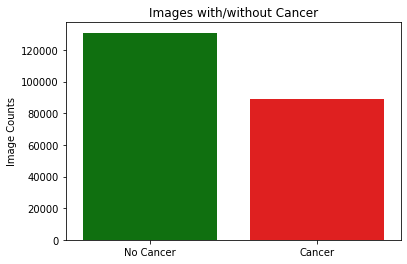

In [11]:
fig,ax = plt.subplots()
fig = sns.countplot(x=train['label'], palette = ['Green','Red']).set(title='Images with/without Cancer')
ax.set_xticklabels(['No Cancer', 'Cancer'])
ax.set(xlabel=None)
ax.set(ylabel='Image Counts')
plt.show()

There appears to be about 1.5 times more images without cancer than with cancer.

In [12]:
def append_tif(string): #adding .tif so file is readable
    return string+".tif"
train["id"] = train["id"].apply(append_tif)
train['label'] = train['label'].astype(str) #converting to string
train = shuffle(train) #shuffling train data

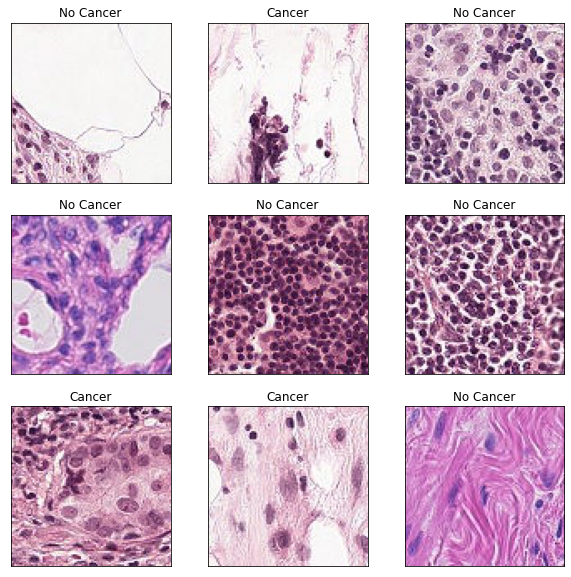

In [13]:
fig, axis = plt.subplots(3, 3, figsize=(10, 10)) #images o
for i, axis in enumerate(axis.flat):
    file = str(path_train + train.id[i])
    image = io.imread(file)
    axis.imshow(image)
    if train.label[i] == '1':
      axis.set_title('Cancer')
    else:
      axis.set_title("No Cancer")
    axis.set(xticks=[], yticks=[]);

In [14]:
tpu = None
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

Number of accelerators:  1


In [15]:
# generating training data
BATCH_SIZE = 64
datagen = ImageDataGenerator(rescale=1./255.,
                            validation_split=0.2)
train_generator = datagen.flow_from_dataframe(
    dataframe=train,
    directory=path_train,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=BATCH_SIZE,
    seed=RANDOM_STATE,
    class_mode="binary",
    target_size=(64,64))  

Found 176020 validated image filenames belonging to 2 classes.


In [16]:
# generating validation data
valid_generator = datagen.flow_from_dataframe(
    dataframe=train,
    directory=path_train,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=BATCH_SIZE,
    seed=RANDOM_STATE,
    class_mode="binary",
    target_size=(64,64))  

Found 44005 validated image filenames belonging to 2 classes.


In [17]:
TRAIN_GEN_STEPS = len(train_generator)
VALID_GEN_STEPS = len(valid_generator)

# Modeling

## Model 1


We will be using a **dropout** of 0.5 to help mitigihate overfitting of the training data. It is generally good practice to have a dropout between 0.5 and 0.8. It many be overkill to include both dropout and batch normalization but I decided to keep both anyways. 
https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/

I chose to use **3x3 filters** and a **ReLu activation function** for each convolution layer since they are the most commonly used to build CNN. Here is a link for more info about different activatoin functions. 

https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6

Note: The default **optimizer** of a Keras CNN is **Adam**, an optimizer that takes the advantages of both RMSProp and AdaGrad. 
https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

In [23]:
#tpu would not allocate properly so lower batch size was used to deal with OOM erros
with strategy.scope():
  ROC_1 = tf.keras.metrics.AUC() 
  model_one = keras.models.Sequential()
  model_one.add(Conv2D(filters=32, kernel_size=(3,3),activation='relu'))
  model_one.add(Conv2D(filters=32, kernel_size=(3,3),activation='relu'))
  model_one.add(MaxPooling2D(pool_size=(2,2)))
  model_one.add(Dropout(0.5)) 
  model_one.add(BatchNormalization())
  model_one.add(Conv2D(filters=32, kernel_size=(3,3),activation='relu'))
  model_one.add(Conv2D(filters=32, kernel_size=(3,3),activation='relu'))
  model_one.add(AveragePooling2D(pool_size=(2,2)))
  model_one.add(Dropout(0.5)) 
  model_one.add(BatchNormalization()) 
  model_one.add(Conv2D(filters=32, kernel_size=(3,3),activation='relu'))
  model_one.add(Flatten())
  model_one.add(Dense(8, activation='relu')) #two fully connected layers is common practice (generally allows for better classification metrics)
  model_one.add(Dense(1, activation='sigmoid'))
  model_one.build(input_shape=(64, 64, 64, 3))     
  adam = Adam(learning_rate=0.0002)
  model_one.compile(loss='binary_crossentropy', metrics=['accuracy', ROC_1],optimizer = adam, run_eagerly = True)
model_one.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (64, 62, 62, 32)          896       
                                                                 
 conv2d_16 (Conv2D)          (64, 60, 60, 32)          9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (64, 30, 30, 32)         0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (64, 30, 30, 32)          0         
                                                                 
 batch_normalization_6 (Batc  (64, 30, 30, 32)         128       
 hNormalization)                                                 
                                                                 
 conv2d_17 (Conv2D)          (64, 28, 28, 32)         

In [24]:
EPOCHS = 8 #to reduce training time

history_model_one = model_one.fit(
                        x = train_generator,
                        steps_per_epoch = TRAIN_GEN_STEPS,
                        epochs = EPOCHS,
                        validation_data = valid_generator,
                        validation_steps=VALID_GEN_STEPS)

Epoch 1/8
2751/2751 [==============================] - 298s 108ms/step - loss: 0.4021 - accuracy: 0.8206 - auc_3: 0.8927 - val_loss: 0.7531 - val_accuracy: 0.7589 - val_auc_3: 0.7357
Epoch 2/8
2751/2751 [==============================] - 292s 106ms/step - loss: 0.3321 - accuracy: 0.8586 - auc_3: 0.9282 - val_loss: 0.7268 - val_accuracy: 0.7313 - val_auc_3: 0.8739
Epoch 3/8
2751/2751 [==============================] - 293s 106ms/step - loss: 0.3021 - accuracy: 0.8725 - auc_3: 0.9407 - val_loss: 0.3665 - val_accuracy: 0.8526 - val_auc_3: 0.9253
Epoch 4/8
2751/2751 [==============================] - 291s 106ms/step - loss: 0.2860 - accuracy: 0.8803 - auc_3: 0.9470 - val_loss: 0.5920 - val_accuracy: 0.7589 - val_auc_3: 0.9347
Epoch 5/8
2751/2751 [==============================] - 291s 106ms/step - loss: 0.2745 - accuracy: 0.8862 - auc_3: 0.9511 - val_loss: 0.3149 - val_accuracy: 0.8743 - val_auc_3: 0.9573
Epoch 6/8
2751/2751 [==============================] - 290s 106ms/step - loss: 0.2641

The model performed extremely well on both the traininga nd validation data for both metrics given. 

In [ ]:
#saving model history
import os.path
if os.path.isfile('drive/MyDrive/Cancer_Detection/cancer_detection_mod1.h5') is False:
  history_model_one.save('drive/MyDrive/Cancer_Detection/cancer_detection_mod1.h5')

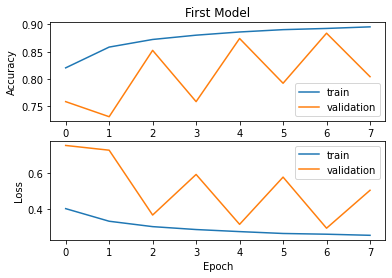

In [71]:
fig, (ax1,ax2) = plt.subplots(2,1)
ax1.plot(history_model_one.history['accuracy'])
ax1.plot(history_model_one.history['val_accuracy'])
ax1.set_title('First Model')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['train', 'validation'])

ax2.plot(history_model_one.history['loss'])
ax2.plot(history_model_one.history['val_loss'])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(['train', 'validation'])

plt.show()

## Model 2

The second model will use efficientnet followed by an average pooling and then finally 3 fully connected dense layersinto an output for each image in the batch (64 images). 

In [43]:
with strategy.scope():
  efficient_net = EfficientNetB3(
    weights='imagenet',
    input_shape=(64,64,3),
    include_top=False,
    pooling='avg'
)

  model2 = Sequential()
  for layer in efficient_net.layers: #so weights trained on 'imagenet data' isn't trained again  
        layer.trainable=False #note that training again would likely lead to much better metrics
  model2.add(efficient_net)
  model2.add(Dense(units = 128, activation='relu'))
  model2.add(Dense(units = 32, activation = 'relu'))
  model2.add(Dense(units = 1, activation='sigmoid'))
  model2.summary()
  model2.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 dense_18 (Dense)            (None, 128)               196736    
                                                                 
 dense_19 (Dense)            (None, 32)                4128      
                                                                 
 dense_20 (Dense)            (None, 1)                 33        
                                                                 
Total params: 10,984,432
Trainable params: 200,897
Non-trainable params: 10,783,535
_________________________________________________________________


In [44]:
history = model2.fit(
              x = train_generator,
              steps_per_epoch = TRAIN_GEN_STEPS,
              epochs = EPOCHS,
              validation_data = valid_generator,
              validation_steps=VALID_GEN_STEPS)

Epoch 1/8
2751/2751 [==============================] - 148s 49ms/step - loss: 0.6317 - accuracy: 0.6348 - val_loss: 0.5870 - val_accuracy: 0.6811
Epoch 2/8
2751/2751 [==============================] - 135s 49ms/step - loss: 0.6086 - accuracy: 0.6621 - val_loss: 0.5878 - val_accuracy: 0.6789
Epoch 3/8
2751/2751 [==============================] - 136s 49ms/step - loss: 0.6031 - accuracy: 0.6677 - val_loss: 0.5844 - val_accuracy: 0.6837
Epoch 4/8
2751/2751 [==============================] - 134s 49ms/step - loss: 0.6017 - accuracy: 0.6686 - val_loss: 0.5799 - val_accuracy: 0.6858
Epoch 5/8
2751/2751 [==============================] - 134s 49ms/step - loss: 0.5994 - accuracy: 0.6695 - val_loss: 0.5818 - val_accuracy: 0.6856
Epoch 6/8
2751/2751 [==============================] - 133s 48ms/step - loss: 0.5964 - accuracy: 0.6719 - val_loss: 0.5775 - val_accuracy: 0.6898
Epoch 7/8
2751/2751 [==============================] - 134s 49ms/step - loss: 0.5958 - accuracy: 0.6718 - val_loss: 0.5772 -

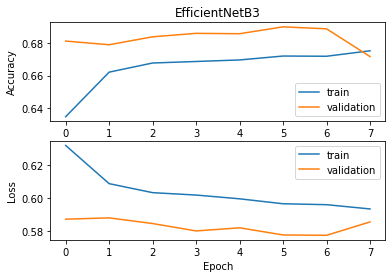

In [68]:
fig, (ax1,ax2) = plt.subplots(2,1)
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('EfficientNetB3')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['train', 'validation'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(['train', 'validation'])

plt.show()

The modle utilizing the efficientnet3 architecture performed worse than expected. This si probably due to the fact I used efficientnet due to its favorable runtime and proboably should have chosen a more suitable pretrained model for this use case.

## Submission

In [72]:
test_df = pd.DataFrame({'id':os.listdir(path_test)})
test_df.head()

,id
0,8cec25062ca876ad60ce232da84ad4fb8b5df02b.tif
1,07c44ccc5e5e228270b9d7b2eae72626ff82f742.tif
2,0d3cfb3b9fe6e1789443e1d261b8edbfb2465a6f.tif
3,ee1e368845df36843aa8f9b18706fbe116945a0d.tif
4,2d8c157793fa3c8feaa54792d422f8419399b115.tif


In [73]:
datagen_test = ImageDataGenerator(rescale=1./255.)

test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_df,
    directory=path_test,
    x_col='id', 
    y_col=None,
    target_size=(64,64),         
    batch_size=64,
    shuffle=False,
    class_mode=None)

Found 57458 validated image filenames.


In [74]:
preds = model_one.predict(test_generator, verbose=2)
preds_new = np.transpose(preds)[0]
submission_df = pd.DataFrame()
submission_df['id'] = test_df['id'].apply(lambda x: x.split('.')[0])
submission_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, preds_new))
submission_df.head()

898/898 - 44s - 44s/epoch - 49ms/step


,id,label
0,8cec25062ca876ad60ce232da84ad4fb8b5df02b,0
1,07c44ccc5e5e228270b9d7b2eae72626ff82f742,0
2,0d3cfb3b9fe6e1789443e1d261b8edbfb2465a6f,1
3,ee1e368845df36843aa8f9b18706fbe116945a0d,1
4,2d8c157793fa3c8feaa54792d422f8419399b115,0


In [79]:
submission_df.to_csv('submission2.csv', index=False)

In [82]:
!realpath -s submission2.csv #grabbing file location to submit

/content/submission2.csv


# Conclusion
I was shocked with how simple it was to create a model that performed moderately well after just learning about Convolutoinal Neural Networks the first time a couple of days ago. Keras made the model-building process extremely easy. The future of data science appears to be heading in the direction of having pretrained models doing majority of the work and taking a process that would normally take months into a training process that will take hours or days. I will definitely need to work on improving my knowledge with transfer learning and will apply transformers using HuggingFace for an NLP task. 